## Project 2. Part 2 (Explore, Clean & Model)

In [1668]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

### Define some useful functions

In [1669]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Petrol and 1 for Diesel.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(0)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values
        

### Unpickle the file

In [1695]:
with open('car_ad_dataset.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,"Not exploited in Lithuania,Available for leasi...",44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
1,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,NaN,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
2,"CD player,CD changer,Original audio system",Saloon / sedan,NaN,Gray / silver,6.80,Crashed,2005-04,Front wheel drive (FWD),"Electric mirrors,Electric windows,Outside temp...","2496 cm³, 163 HP (120kW)",...,"Not exploited in Lithuania,Service book",3 300 €\n \n Sužinokite įmoką\n ...,"ABS,ESP iElectronic stability program$(""#rel_E...",Central locking,Left hand drive (LHD),NaN,9.60,\n \n Check vehicle history\...,NaN,NaN
3,"CD player,Original audio system,Handsfree kit",Saloon / sedan,Climate control,Gray / silver,4.90,No damages,2006,Front wheel drive (FWD),"Electric mirrors,Electric windows,Automatic he...","1560 cm³, 110 HP (81kW)",...,Service book,3 900 €\n \n Sužinokite įmoką\n ...,"ABS,Traction control system,ESP iElectronic st...",Central locking,Left hand drive (LHD),NaN,6.20,\n \n Check vehicle history\...,NaN,NaN
4,"CD player,AUX input,USB input",Hatchback,Climate control,NaN,NaN,No damages,2011-04,Rear wheel drive (RWD),"Electric mirrors,Electric windows,Outside temp...","2000 cm³, 142 HP (105kW)",...,"Not exploited in Lithuania,Available for leasi...",6 000 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN


In [1696]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (3020, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 35 columns):
Audio/video equipment         357 non-null object
Body type                     563 non-null object
Climate control               344 non-null object
Color                         452 non-null object
Combined                      243 non-null object
Damage                        563 non-null object
Date of manufacture           563 non-null object
Driven wheels                 420 non-null object
Electronics                   472 non-null object
Engine                        554 non-null object
Engine_Size                   563 non-null object
Euro standard                 152 non-null object
Export price                  124 non-null object
Exterior                      460 non-null object
Extra-urban                   246 non-null object
First registration country    282 non-null object
Fuel type                     563 non-null object
Gearbox         

In [1672]:
car_ad_dataset.describe()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
count,357,563,344,452,243,563,563,420,472,554,...,299,563,430,326,563,26,239,561,75,323
unique,134,10,3,11,66,5,211,3,206,323,...,38,184,36,11,2,6,78,2,75,9
top,"CD player,Original audio system",Wagon,Climate control,Gray / silver,6.00,No damages,2005,Front wheel drive (FWD),Electric windows,"2000 cm³, 149 HP (110kW)",...,"Not exploited in Lithuania,Service book,Cataly...",2 500 €\n \n Sužinokite įmoką\n ...,Airbags,"Central locking,Immobilizer,Alarm",Left hand drive (LHD),Increased engine power,6.00,\n \n Check vehicle history\...,JM1BK32G161492541,R16
freq,57,142,226,171,21,538,14,303,90,10,...,40,16,119,93,553,11,15,486,1,115


In [1673]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       563
Price in Lithuania            563
Fuel type                     563
Make_Model                    563
Number of doors               563
Date of manufacture           563
Engine_Size                   563
Damage                        563
Steering wheel                563
Body type                     563
VIN check                     561
Engine                        554
Interior                      478
Electronics                   472
Exterior                      460
Color                         452
Mileage                       445
Safety                        430
Driven wheels                 420
Number of seats               411
Audio/video equipment         357
Climate control               344
MOT test expiry               338
Security                      326
Wheel size                    323
Other features                299
First registration country    282
Extra-urban                   246
Combined                      243
Urban         

### Clean the dataset

**Initial cleaning and formatting**

In [1674]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [1675]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [1676]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [1677]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [1678]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [1679]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [1680]:
#Sanity check (values in fuel type)
car_ad_dataset['Fuel type'].unique()

array(['Diesel', 'Petrol', 'Petrol / LPG', 'Diesel / gas', 'Other',
       'Petrol / electricity', nan], dtype=object)

In [1681]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

**Shorten the dataset & re-evaluate**

In [1682]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Make', 'Model', 'Body type', 'Year_of_manufacture', 'Damage', 'Engine_Size_l', 'Fuel type', 'Gearbox', 'Mileage_km','Number of doors', 'Color', 'Steering wheel', 'Price']]
short_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Damage,Engine_Size_l,Fuel type,Gearbox,Mileage_km,Number of doors,Color,Steering wheel,Price
0,BMW,520,Wagon,2018.0,No damages,2.0,1.0,Automatic,8100.0,4/5,Black,Left hand drive (LHD),44900.0
1,Toyota,MR 2,Coupe,1992.0,No damages,2.0,0.0,Manual,270000.0,2/3,Blue,Left hand drive (LHD),4400.0
2,Audi,A4,Saloon / sedan,2005.0,Crashed,2.5,1.0,Manual,265000.0,4/5,Gray / silver,Left hand drive (LHD),3300.0
3,Volvo,S40,Saloon / sedan,2006.0,No damages,1.6,1.0,Manual,241000.0,4/5,Gray / silver,Left hand drive (LHD),3900.0
4,BMW,120,Hatchback,2011.0,No damages,2.0,1.0,Manual,193000.0,4/5,NaN,Left hand drive (LHD),6000.0


In [1683]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 13 columns):
Make                   563 non-null object
Model                  563 non-null object
Body type              563 non-null object
Year_of_manufacture    563 non-null float64
Damage                 563 non-null object
Engine_Size_l          541 non-null float64
Fuel type              561 non-null float64
Gearbox                563 non-null object
Mileage_km             445 non-null float64
Number of doors        563 non-null object
Color                  452 non-null object
Steering wheel         563 non-null object
Price                  563 non-null float64
dtypes: float64(5), object(8)
memory usage: 306.8+ KB


**Clean the small dataset of NaN values**

In [1684]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 562
Data columns (total 13 columns):
Make                   361 non-null object
Model                  361 non-null object
Body type              361 non-null object
Year_of_manufacture    361 non-null float64
Damage                 361 non-null object
Engine_Size_l          361 non-null float64
Fuel type              361 non-null float64
Gearbox                361 non-null object
Mileage_km             361 non-null float64
Number of doors        361 non-null object
Color                  361 non-null object
Steering wheel         361 non-null object
Price                  361 non-null float64
dtypes: float64(5), object(8)
memory usage: 39.5+ KB


In [1685]:
#Let's have a look again
clean_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Damage,Engine_Size_l,Fuel type,Gearbox,Mileage_km,Number of doors,Color,Steering wheel,Price
0,BMW,520,Wagon,2018.0,No damages,2.0,1.0,Automatic,8100.0,4/5,Black,Left hand drive (LHD),44900.0
1,Toyota,MR 2,Coupe,1992.0,No damages,2.0,0.0,Manual,270000.0,2/3,Blue,Left hand drive (LHD),4400.0
2,Audi,A4,Saloon / sedan,2005.0,Crashed,2.5,1.0,Manual,265000.0,4/5,Gray / silver,Left hand drive (LHD),3300.0
3,Volvo,S40,Saloon / sedan,2006.0,No damages,1.6,1.0,Manual,241000.0,4/5,Gray / silver,Left hand drive (LHD),3900.0
6,Mazda,3,Hatchback,2008.0,Crashed,1.6,1.0,Manual,193533.0,4/5,Gray / silver,Left hand drive (LHD),1499.0


In [1686]:
#Remove cars that are damaged
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Damage'] == 'No damages']
clean_car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
clean_car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#Rename the Fuel type column
clean_car_ad_dataset = clean_car_ad_dataset.rename(columns = {'Fuel type': 'Fuel_type'})

#Clean up Engine_cm3 column from potential HP values --NOT WORKING!!!
#clean_car_ad_dataset['Engine_cm3'] = clean_car_ad_dataset[clean_car_ad_dataset['Engine_cm3'] > 600.0]
#clean_car_ad_dataset['Engine_cm3']

clean_car_ad_dataset.head()

,Make,Model,Body type,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Number of doors,Color,Price
0,BMW,520,Wagon,2018.0,2.0,1.0,Automatic,8100.0,4/5,Black,44900.0
1,Toyota,MR 2,Coupe,1992.0,2.0,0.0,Manual,270000.0,2/3,Blue,4400.0
3,Volvo,S40,Saloon / sedan,2006.0,1.6,1.0,Manual,241000.0,4/5,Gray / silver,3900.0
10,Renault,Espace,MPV / minivan,1998.0,2.0,0.0,Manual,320000.0,4/5,Green / olive,450.0
12,BMW,320,Coupe,2001.0,2.2,0.0,Manual,271000.0,2/3,Blue,2450.0


In [1687]:
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 562
Data columns (total 11 columns):
Make                   338 non-null object
Model                  338 non-null object
Body type              338 non-null object
Year_of_manufacture    338 non-null float64
Engine_Size_l          338 non-null float64
Fuel_type              338 non-null float64
Gearbox                338 non-null object
Mileage_km             338 non-null float64
Number of doors        338 non-null object
Color                  338 non-null object
Price                  338 non-null float64
dtypes: float64(5), object(6)
memory usage: 31.7+ KB


### Let's try modelling

In [1688]:
#Check the correlation between different variables
clean_car_ad_dataset.corr()

,Year_of_manufacture,Engine_Size_l,Fuel_type,Mileage_km,Price
Year_of_manufacture,1.000000,-0.091766,0.280712,-0.133227,0.548427
Engine_Size_l,-0.091766,1.000000,0.196368,0.088020,0.243076
Fuel_type,0.280712,0.196368,1.000000,0.123400,0.172887
Mileage_km,-0.133227,0.088020,0.123400,1.000000,-0.120990
Price,0.548427,0.243076,0.172887,-0.120990,1.000000


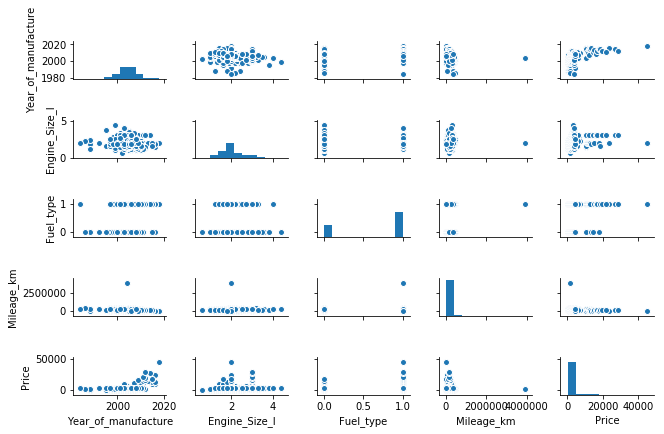

In [1689]:
#Visualize the correlations
sns.pairplot(clean_car_ad_dataset, size = 1.2, aspect=1.5);

In [1690]:
#Create the feature matrix and target vector
y, X = patsy.dmatrices('Price ~ Year_of_manufacture + Engine_Size_l + Mileage_km + Fuel_type', clean_car_ad_dataset)
car_ad_model = sm.OLS(y, X)
car_ad_model_fit = car_ad_model.fit()
car_ad_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     54.18
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           3.80e-35
Time:                        23:59:43   Log-Likelihood:                -3227.2
No. Observations:                 338   AIC:                             6464.
Df Residuals:                     333   BIC:                             6484.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.111e+06   8.73e+04    -12.717      0.000   -1.28e+06   -9.39e+05
Year_of_manufacture   553.6972     43.558     12.712      0.000     468.014     639.380
Engine_Size_l        2563.3994    363.827      7.046      0.000    1847.710    3279.089
Mileage_km             -0.0013      0.001     -1.504      0.133      -0.003       0.000
Fuel_type            -397.5084    429.167     -0.926      0.355   -1241.729     446.712
==============================================================================
Omnibus:                      355.440   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16146.370
Skew:                           4.481   Prob(JB):                         0.00
Kurtosis:                      35.652   Cond. No.                     1.50e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

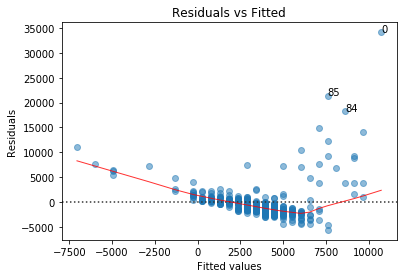

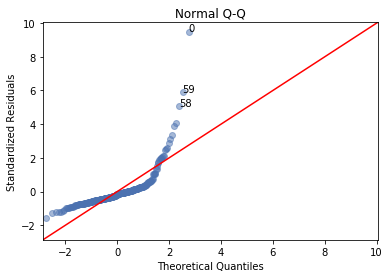

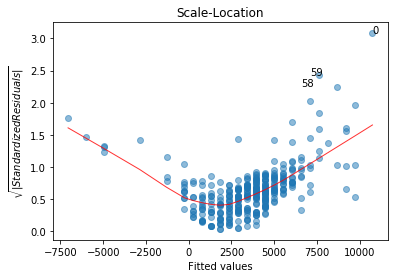

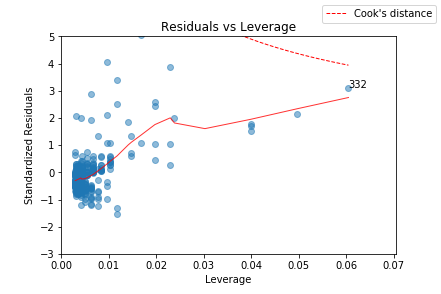

In [1691]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset['Year_of_manufacture'], clean_car_ad_dataset['Price']);


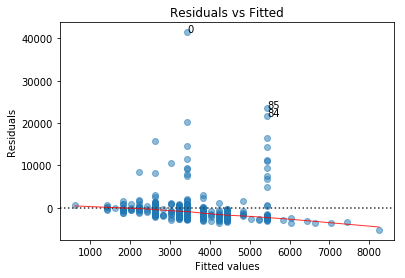

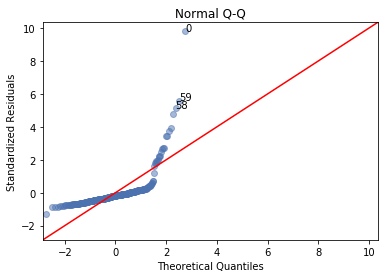

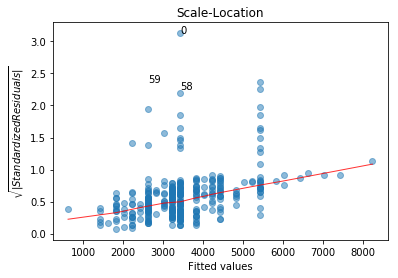

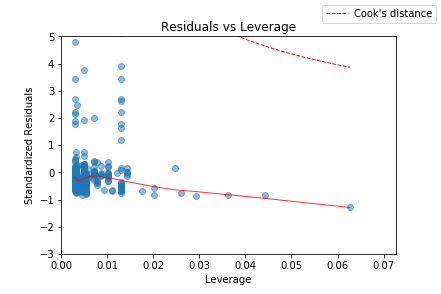

In [1692]:
# Use diagnostic_plots python file to plot Engine Size (l) results
diagnostic_plots(clean_car_ad_dataset['Engine_Size_l'], clean_car_ad_dataset['Price'])

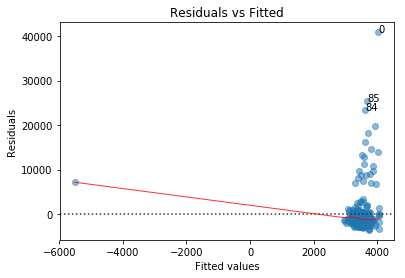

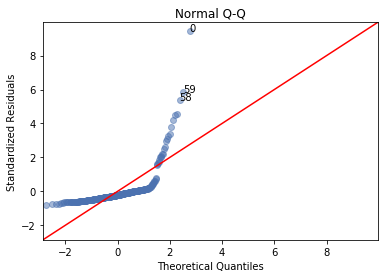

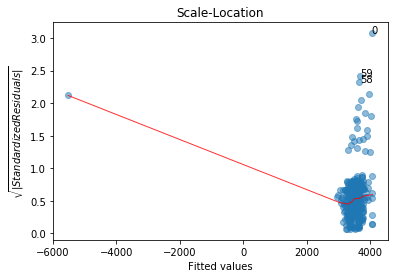

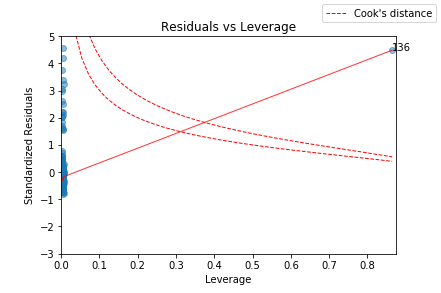

In [1693]:
# Use diagnostic_plots python file to plot Mileage (km) results
diagnostic_plots(clean_car_ad_dataset['Mileage_km'], clean_car_ad_dataset['Price'])

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


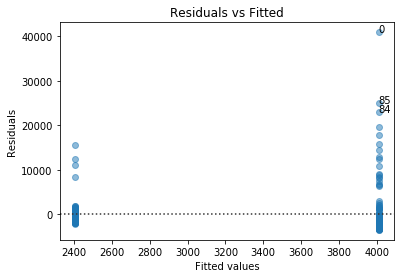

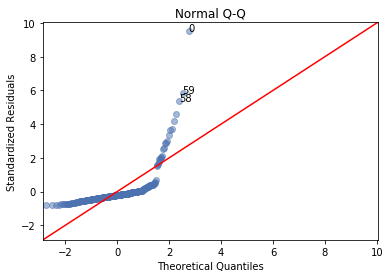

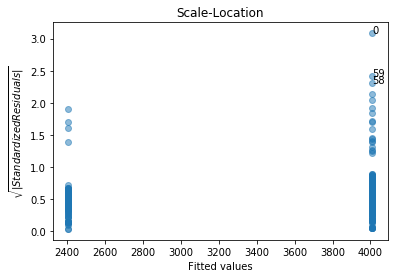

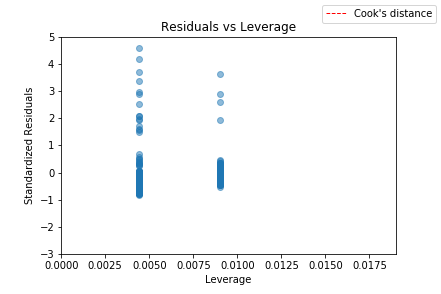

In [1694]:
# Use diagnostic_plots python file to plot Fuel type results
diagnostic_plots(clean_car_ad_dataset['Fuel_type'], clean_car_ad_dataset['Price'])